# 25 - Diferença em Diferenças Sintética

Em capítulos anteriores, exploramos os métodos de Diferença em Diferenças e Controle Sintético para identificar o efeito do tratamento com dados em painel (dados em que temos várias unidades observadas ao longo de vários períodos de tempo). Acontece que podemos unir ambos os enfoques em um único estimador. Este novo procedimento de estimação de Diferença em Diferenças Sintéticas consegue explorar as vantagens de ambos os métodos, ao mesmo tempo em que aumenta a precisão (diminuindo as barras de erro) da estimativa do efeito do tratamento.
 
Vamos discutir Diferença em Diferenças Sintéticas principalmente no caso de **atribuição de tratamento em blocos**. Isso significa que observamos várias unidades ao longo do tempo e, ao mesmo tempo, algumas unidades são tratadas, enquanto outras permanecem não tratadas. Podemos visualizar isso por meio de uma matriz de atribuições de tratamento $D$, onde as **colunas da matriz são unidades** e as **linhas da matriz são períodos de tempo**.
 
$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$
 
Para tornar as coisas mais concretas, vamos acompanhar o exemplo de estimar o impacto da Proposição 99 no consumo de cigarros na Califórnia. Neste caso, temos apenas uma unidade tratada, a Califórnia, que recebe tratamento (aprovação da Proposição 99) em algum momento no tempo (novembro de 1988, para ser preciso). Se considerarmos a Califórnia como a última coluna da matriz, obtemos algo como:
 
$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$
 
Observe que aqui estamos apenas falando sobre o caso em que todas as unidades tratadas recebem o tratamento **ao mesmo tempo**. No final, discutiremos como lidar com a **atribuição de tratamento adotada de forma escalonada**, onde o tratamento é gradualmente implementado nas unidades, fazendo com que elas o recebam em momentos diferentes. A única condição necessária nesse desenho é que, uma vez que uma unidade seja tratada, ela não reverta para a condição de não tratada.
 
Voltando ao caso simples, onde todas as unidades são tratadas ao mesmo tempo, podemos simplificar a matriz de atribuição de tratamento em quatro blocos, cada um representado por outra matriz. Em geral, à medida que avançamos na matriz, estamos avançando no tempo. Também agruparemos as unidades tratadas à direita da matriz. Como resultado, o primeiro bloco em nossa matriz (canto superior esquerdo) corresponde às unidades de controle antes do período de tratamento; o segundo bloco (canto superior direito) corresponde às unidades tratadas antes do período de tratamento; o terceiro bloco (canto inferior esquerdo) contém as unidades de controle após o período de tratamento, e o quarto bloco (canto inferior direito) é a unidade tratada após o período de tratamento. O indicador de tratamento é zero em todos os lugares, exceto no bloco com as unidades tratadas após o período de tratamento.
 
$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$
 
Essa matriz de atribuição resultará na seguinte matriz de resultados:
 
$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$
 
Novamente, observe como o período pós-tratamento está na parte inferior e as unidades tratadas estão à direita.

Em nosso exemplo de estimar o efeito da Proposição 99, o resultado $Y$ são as vendas de cigarros. Usamos $pre$ e $post$ para representar o período anterior e posterior ao tratamento, respectivamente, e $co$ e $tr$ para representar a unidade de controle e tratada, respectivamente.
 
Usaremos a representação da matriz acima sempre que falarmos sobre a estimativa dos pesos de controle sintético, mas também há outra representação de dados que é útil, especialmente se estivermos falando sobre DiD. Nesta representação, temos uma tabela com 5 colunas: uma representando as unidades, uma representando os períodos de tempo, a coluna de resultado e duas colunas booleanas marcando as unidades tratadas e o período de tratamento. O número de linhas nesta tabela é o número de unidades $N$ vezes o número de períodos $T$. Aqui está como os dados da Proposição 99 se parecem:

In [61]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

In [35]:
# data = pd.read_csv("gsynth R/simdata_gsynth.csv", sep='\t')

# # Determinar o menor tempo de tratamento (time quando D == 1) para cada ID
# treatment_time = data.loc[data['D'] == 1].groupby('id')['time'].min().reset_index()
# treatment_time.columns = ['id', 'treatment_start']

# # Juntar ao DataFrame original
# data = data.merge(treatment_time, on='id', how='left')

# # Criar a coluna pré/pós-tratamento
# data['pre_post'] = data.apply(
#     lambda row: 'Controle' if pd.isnull(row['treatment_start']) else 
#                 ('Pré Tratamento' if row['time'] < row['treatment_start'] else 'Pós Tratamento'),
#     axis=1
# )


In [69]:
data = pd.read_csv("gsynth R/turnout_gsynth.csv", sep='\t')

# Determinar o menor tempo de tratamento (time quando D == 1) para cada ID
treatment_time = data.loc[data['policy_edr'] == 1].groupby('abb')['year'].min().reset_index()
treatment_time.columns = ['abb', 'treatment_start']

# Juntar ao DataFrame original
data = data.merge(treatment_time, on='abb', how='left')

# Criar a coluna pré/pós-tratamento
data['pre_post'] = data.apply(
    lambda row: 'Controle' if pd.isnull(row['treatment_start']) else 
                ('Pré Tratamento' if row['year'] < row['treatment_start'] else 'Pós Tratamento'),
    axis=1
)

In [71]:
# Converter variáveis categóricas para numéricas
if 'pre_post' in data.columns:
    data['pre_pos_tratamento_encoded'] = data['pre_post'].map({
        'Controle': 0, 
        'Pré Tratamento': 1, 
        'Pós Tratamento': 2
    })

# Verificar se há outras colunas categóricas a serem codificadas
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    data[col] = pd.Categorical(data[col]).codes  # Converter para códigos numéricos

# Confirmar que as colunas são numéricas
print(data.dtypes)


abb                              int8
year                            int64
turnout                       float64
policy_edr                      int64
policy_mail_in                  int64
policy_motor                    int64
treatment_start               float64
pre_post                         int8
pre_pos_tratamento_encoded      int64
dtype: object


In [43]:
# Criar a coluna pré/pós-tratamento
data['after_tratament'] = data.apply(
    lambda row: 
                ('Pré Tratamento' if row['year'] < row['treatment_start'] else 'Pós Tratamento'),
    axis=1
)

In [39]:
data[data.abb=='AL']

,abb,year,turnout,policy_edr,policy_mail_in,policy_motor,treatment_start,pre_post,after_tratament
0,AL,1920,21.021074,0,0,0,NaN,Controle,Pós Tratamento
1,AL,1924,13.582329,0,0,0,NaN,Controle,Pós Tratamento
2,AL,1928,19.038504,0,0,0,NaN,Controle,Pós Tratamento
3,AL,1932,17.620020,0,0,0,NaN,Controle,Pós Tratamento
4,AL,1936,18.692375,0,0,0,NaN,Controle,Pós Tratamento
5,AL,1940,18.864061,0,0,0,NaN,Controle,Pós Tratamento
6,AL,1944,14.966900,0,0,0,NaN,Controle,Pós Tratamento
7,AL,1948,12.566221,0,0,0,NaN,Controle,Pós Tratamento
8,AL,1952,24.134014,0,0,0,NaN,Controle,Pós Tratamento
9,AL,1956,27.606144,0,0,0,NaN,Controle,Pós Tratamento


In [3]:
data[data.abb=='ME']

,abb,year,turnout,policy_edr,policy_mail_in,policy_motor,treatment_start,pre_post
384,ME,1920,43.119965,0,0,0,1976.0,Pré Tratamento
385,ME,1924,40.879929,0,0,0,1976.0,Pré Tratamento
386,ME,1928,54.453037,0,0,0,1976.0,Pré Tratamento
387,ME,1932,60.128216,0,0,0,1976.0,Pré Tratamento
388,ME,1936,59.100056,0,0,0,1976.0,Pré Tratamento
389,ME,1940,60.169159,0,0,0,1976.0,Pré Tratamento
390,ME,1944,53.825260,0,0,0,1976.0,Pré Tratamento
391,ME,1948,46.608273,0,0,0,1976.0,Pré Tratamento
392,ME,1952,60.897861,0,0,0,1976.0,Pré Tratamento
393,ME,1956,60.708801,0,0,0,1976.0,Pré Tratamento


# Visualizando o tratamento no tempo (similar ao pacote gsynth do R)

* panelview(Y ~ D, data = simdata,  index = c("id","time"), pre.post = TRUE) 


In [ ]:
# pip install plotnine

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import pandas as pd

def tratamento_no_tempo(dataframe, unidade, tempo, pre_pos_tratamento):
    # Garantir a ordem desejada para a coluna 'pre_pos_tratamento'
    ordem = ['Controle', 'Pré Tratamento', 'Pós Tratamento']
    dataframe[pre_pos_tratamento] = pd.Categorical(dataframe[pre_pos_tratamento], categories=ordem, ordered=True)

    # Encontrar o primeiro tempo de tratamento para cada unidade (considerando somente os grupos de tratamento)
    def get_first_treatment_time(group):
        # Encontra o primeiro tempo que foi feito o tratamento (ignora controle)
        treatment_times = group[group[pre_pos_tratamento] != 'Controle'][tempo]
        return treatment_times.min() if not treatment_times.empty else float('inf')

    # Cria uma nova coluna 'first_treatment_time' para armazenar o primeiro tempo de tratamento
    dataframe['first_treatment_time'] = dataframe.groupby(unidade).apply(get_first_treatment_time).reset_index(level=0, drop=True)

    # Ordenar as unidades pelo primeiro tempo de tratamento, e depois pelo tratamento (Controle vai para o final)
    dataframe = dataframe.sort_values(by=['first_treatment_time', pre_pos_tratamento, unidade])

    # Reestruturar os dados para o heatmap
    # Atribuindo valores numéricos às categorias
    dataframe['heatmap_values'] = dataframe[pre_pos_tratamento].map({'Controle': 0, 'Pré Tratamento': 1, 'Pós Tratamento': 2})

    # Garantir que 'heatmap_values' seja numérico e substituir valores nulos por 0
    dataframe['heatmap_values'] = pd.to_numeric(dataframe['heatmap_values'], errors='coerce')
    dataframe['heatmap_values'] = dataframe['heatmap_values'].fillna(0)  # Substituir NaN por 0 (ou outro valor desejado)

    # Criando a tabela pivô para o heatmap
    pivoted = dataframe.pivot_table(index=unidade, columns=tempo, values='heatmap_values', aggfunc='first')

    # Configurar colormap
    cmap = ListedColormap(['blue', 'lightpink', 'red'])  # Controle, Pré, Pós

    # Plotando visualização
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivoted, cmap=cmap, cbar=False, linewidths=.5)

    # Adicionando título e rótulos
    plt.title('Visualização de Tratamento no Tempo', fontsize=16)
    plt.xlabel('Tempo')
    plt.ylabel('ID')

    # Criando legenda personalizada
    legend_elements = [
        Patch(facecolor="blue", edgecolor="black", label="Controle"),
        Patch(facecolor="lightpink", edgecolor="black", label="Pré-tratamento"),
        Patch(facecolor="red", edgecolor="black", label="Pós-tratamento"),
    ]

    # Adicionando a legenda ao gráfico
    plt.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),  # Posiciona a legenda abaixo do gráfico
        ncol=3,  # Organiza em uma linha
        fontsize=10,
        title="Grupo"
    )

    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()


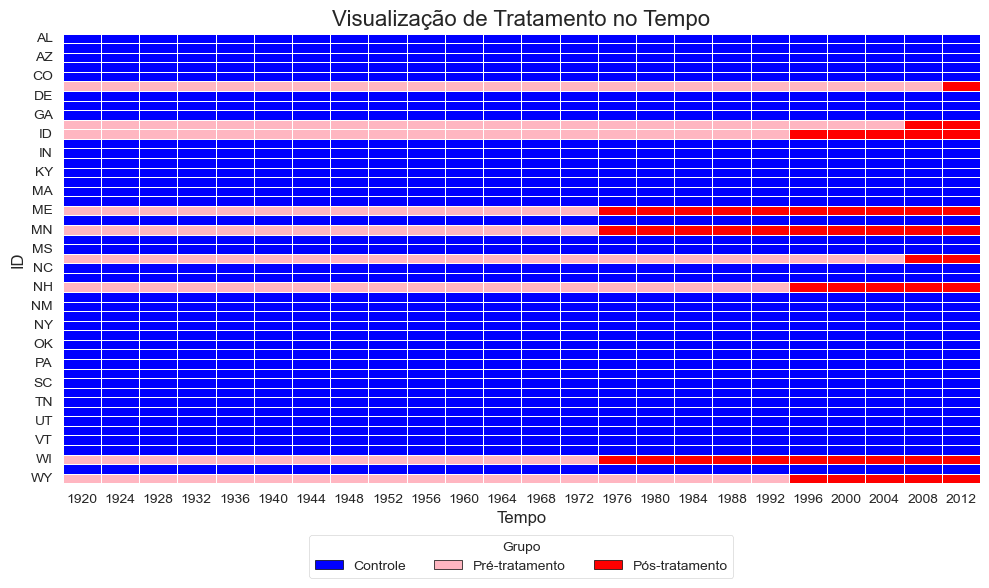

In [87]:
tratamento_no_tempo(data, 'abb', 'year', 'pre_post')

# Maneira de visualizar quando tenho muitos dados

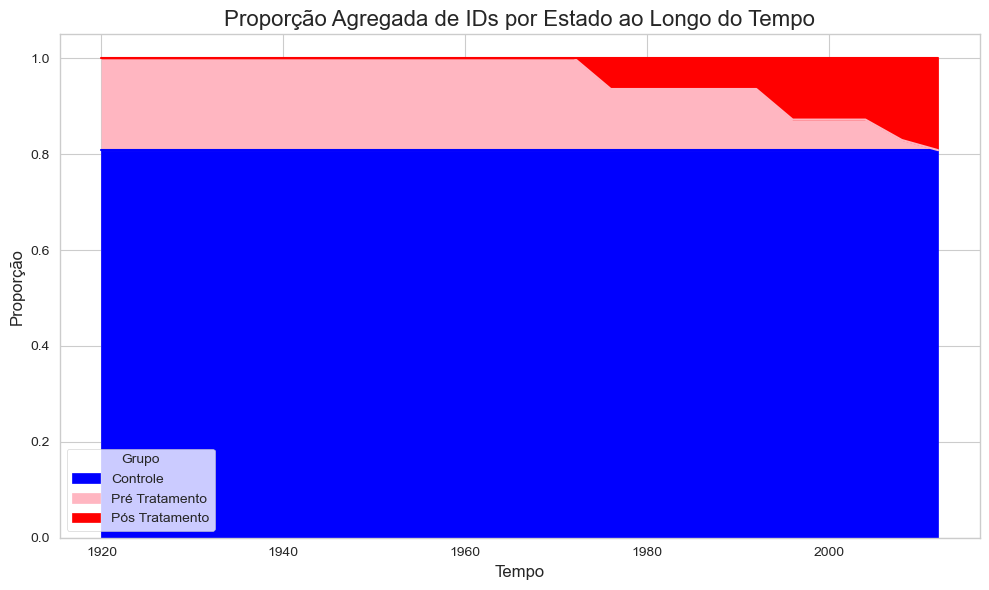

In [89]:
# Calcular proporções por tempo
aggregated_data = data.groupby(['year', 'pre_post']).size().unstack(fill_value=0)
aggregated_data = aggregated_data.div(aggregated_data.sum(axis=1), axis=0)

sns.set_style("whitegrid")  # Use 'whitegrid' ou 'white'

# Plotar gráfico de áreas empilhadas
aggregated_data.plot(kind='area', figsize=(10, 6), color=['blue', 'lightpink', 'red'])

# Configurar título e rótulos
plt.title('Proporção Agregada de IDs por Estado ao Longo do Tempo', fontsize=16)
plt.xlabel('Tempo')
plt.ylabel('Proporção')
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()


# Visualizando o eixo Y no tempo

In [ ]:
# Resumir os dados para o gráfico
# mean_data = data.groupby(['time', 'pre_post'])['Y'].mean().reset_index()

sns.set_style("whitegrid")  # Use 'whitegrid' ou 'white'

# Criar o gráfico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data,
    x='time', 
    y='Y', 
    hue='pre_post', 
    palette={'Controle': 'blue', 'Pré Tratamento': 'lightpink', 'Pós Tratamento': 'red'}
)

# Adicionar título e rótulos
plt.title('Comportamento de Y ao Longo do Tempo', fontsize=16)
plt.xlabel('Tempo')
plt.ylabel('Média de Y')
plt.legend(title='Grupo', loc='upper left', fontsize=10)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Estimativa do pacote turnout do R

 Estimate     S.E.  CI.lower CI.upper    p.value
ATT.avg 4.895788 2.220317 0.5440463  9.24753 0.02745445

In [127]:
# !pip install linearmodels

In [57]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from tqdm import tqdm

# # Simular dados
# np.random.seed(42)
# n = 100  # Número de IDs
# t = 10   # Períodos de tempo

# # Dados simulados
# data = pd.DataFrame({
#     'id': np.repeat(np.arange(1, n+1), t),
#     'time': np.tile(np.arange(1, t+1), n),
#     'D': np.random.choice([0, 1], size=n*t, p=[0.7, 0.3]),
#     'Y': np.random.normal(size=n*t),
#     'X1': np.random.normal(size=n*t),
#     'X2': np.random.normal(size=n*t),
# })

# Adicionar efeitos fixos (dois fatores: individual e temporal)
data['abb_fe'] = data['abb']
data['year_fe'] = data['year']

# Preparar dados para o painel
data = data.set_index(['abb', 'year'])

# Modelo de efeitos fixos bidimensionais
mod = PanelOLS.from_formula(
    'turnout ~ policy_edr  + policy_mail_in  + policy_motor + EntityEffects + TimeEffects', 
    data
)
res = mod.fit(cov_type='clustered', cluster_entity=True)

# Exibir resultados do modelo
print(res)

# Validação cruzada para fatores latentes
def evaluate_model(data, r):
    """
    Ajustar o modelo com um número específico de fatores latentes (r).
    """
    mod = PanelOLS.from_formula(
       'turnout ~ policy_edr  + policy_mail_in  + policy_motor + EntityEffects + TimeEffects', 
        data
    )
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    return res.rsquared

# Grid Search para encontrar o número ótimo de fatores
r_values = range(0, 6)
cv_results = {r: evaluate_model(data, r) for r in r_values}

# Melhor número de fatores
best_r = max(cv_results, key=cv_results.get)
print(f"Melhor número de fatores: {best_r}")

# Inferência paramétrica com Bootstrap
def bootstrap(data, nboots=1000):
    """
    Inferência usando Bootstrap.
    """
    coefs = []
    for _ in tqdm(range(nboots)):
        sample = data.sample(frac=1, replace=True)
        mod = PanelOLS.from_formula(
           'turnout ~ policy_edr  + policy_mail_in  + policy_motor + EntityEffects + TimeEffects', 
            sample
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        coefs.append(res.params['policy_edr'])
    return np.mean(coefs), np.std(coefs)

# Realizar bootstrap
mean_coef, se = bootstrap(data)
print(f"Coeficiente Médio: {mean_coef}, Erro Padrão: {se}")


                          PanelOLS Estimation Summary                           
Dep. Variable:                turnout   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0101
No. Observations:                1128   R-squared (Within):               0.0010
Date:                Mon, Nov 18 2024   R-squared (Overall):             -0.0098
Time:                        08:15:55   Log-likelihood                   -3936.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3925
Entities:                          47   P-value                           0.7585
Avg Obs:                       24.000   Distribution:                  F(3,1055)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             0.2037
                            

100%|██████████| 1000/1000 [01:33<00:00, 10.65it/s]

Coeficiente Médio: 0.7973303389688059, Erro Padrão: 1.1406318344498065


# Estimativa do pacote simdata do R

In [19]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from tqdm import tqdm

# # Simular dados
# np.random.seed(42)
# n = 100  # Número de IDs
# t = 10   # Períodos de tempo

# # Dados simulados
# data = pd.DataFrame({
#     'id': np.repeat(np.arange(1, n+1), t),
#     'time': np.tile(np.arange(1, t+1), n),
#     'D': np.random.choice([0, 1], size=n*t, p=[0.7, 0.3]),
#     'Y': np.random.normal(size=n*t),
#     'X1': np.random.normal(size=n*t),
#     'X2': np.random.normal(size=n*t),
# })

# Adicionar efeitos fixos (dois fatores: individual e temporal)
data['id_fe'] = data['id']
data['time_fe'] = data['time']

# Preparar dados para o painel
data = data.set_index(['id', 'time'])

# Modelo de efeitos fixos bidimensionais
mod = PanelOLS.from_formula(
    'Y ~ 1 + D + X1 + X2 + EntityEffects + TimeEffects', 
    data
)
res = mod.fit(cov_type='clustered', cluster_entity=True)

# Exibir resultados do modelo
print(res)

# Validação cruzada para fatores latentes
def evaluate_model(data, r):
    """
    Ajustar o modelo com um número específico de fatores latentes (r).
    """
    mod = PanelOLS.from_formula(
        'Y ~ 1 + D + X1 + X2 + EntityEffects + TimeEffects', 
        data
    )
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    return res.rsquared

# Grid Search para encontrar o número ótimo de fatores
r_values = range(0, 6)
cv_results = {r: evaluate_model(data, r) for r in r_values}

# Melhor número de fatores
best_r = max(cv_results, key=cv_results.get)
print(f"Melhor número de fatores: {best_r}")

# Inferência paramétrica com Bootstrap
def bootstrap(data, nboots=1000):
    """
    Inferência usando Bootstrap.
    """
    coefs = []
    for _ in tqdm(range(nboots)):
        sample = data.sample(frac=1, replace=True)
        mod = PanelOLS.from_formula(
            'Y ~ 1 + D + X1 + X2 + EntityEffects + TimeEffects', 
            sample
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        coefs.append(res.params['D'])
    return np.mean(coefs), np.std(coefs)

# Realizar bootstrap
mean_coef, se = bootstrap(data)
print(f"Coeficiente Médio: {mean_coef}, Erro Padrão: {se}")


                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.9157
Estimator:                   PanelOLS   R-squared (Between):              0.7781
No. Observations:                1500   R-squared (Within):               0.8710
Date:                Sun, Nov 17 2024   R-squared (Overall):              0.8579
Time:                        15:37:36   Log-likelihood                   -2701.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5133.3
Entities:                          50   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                  F(3,1418)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):             2640.7
                            

100%|██████████| 1000/1000 [01:42<00:00,  9.71it/s]

Coeficiente Médio: 5.086954438305722, Erro Padrão: 0.540929903486982


In [ ]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# # Simular dados
# np.random.seed(42)
# n = 100  # Número de IDs
# t = 10   # Períodos de tempo

# # Dados simulados
# data = pd.DataFrame({
#     'id': np.repeat(np.arange(1, n+1), t),
#     'time': np.tile(np.arange(1, t+1), n),
#     'D': np.random.choice([0, 1], size=n*t, p=[0.7, 0.3]),
#     'Y': np.random.normal(size=n*t),
#     'X1': np.random.normal(size=n*t),
#     'X2': np.random.normal(size=n*t),
# })

# # Preparar dados para o painel
# data = data.set_index(['id', 'time'])

# Função para calcular as métricas de validação cruzada
def cross_validation(data, r_values):
    results = []
    
    for r in r_values:
        # Ajuste do modelo com efeitos fixos e o número de fatores r
        mod = PanelOLS.from_formula(
            'Y ~ 1 + D + X1 + X2 + EntityEffects + TimeEffects', 
            data
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        
        # Calcular as métricas
        sigma2 = np.var(res.resids)
        y_pred = res.fitted_values
        mspe = mean_squared_error(data['Y'], y_pred)
        
        # Exemplo fictício de cálculo do IC e PC
        ic = np.mean(y_pred)  # Usando a média dos valores previstos como IC fictício
        pc = np.mean(data['Y'] - y_pred)  # Usando a diferença entre os valores reais e previstos como PC fictício
        
        results.append({
            'r': r,
            'sigma2': sigma2,
            'IC': ic,
            'PC': pc,
            'MSPE': mspe
        })
    
    # Encontrar o valor de r com menor MSPE
    best_result = min(results, key=lambda x: x['MSPE'])
    return results, best_result

# Valores de r para testar
r_values = range(0, 6)

# Realizar validação cruzada
cv_results, best_r = cross_validation(data, r_values)

# Exibir resultados de validação cruzada
print("Cross-validation Results:")
for res in cv_results:
    print(f"r = {res['r']}; sigma2 = {res['sigma2']:.5f}; IC = {res['IC']:.5f}; PC = {res['PC']:.5f}; MSPE = {res['MSPE']:.5f}")
print(f"\nr* = {best_r['r']}")

# Função de Bootstrap
def bootstrap(data, nboots=1000):
    """
    Inferência usando Bootstrap.
    """
    coefs = []
    for _ in tqdm(range(nboots)):
        sample = data.sample(frac=1, replace=True)
        mod = PanelOLS.from_formula(
            'Y ~ 1 + D + X1 + X2 + EntityEffects + TimeEffects', 
            sample
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        coefs.append(res.params['D'])
    
    mean_coef = np.mean(coefs)
    se = np.std(coefs)
    return mean_coef, se

# Realizar bootstrap
mean_coef, se = bootstrap(data)
print(f"\nBootstrap Results:")
print(f"Coeficiente Médio: {mean_coef:.5f}, Erro Padrão: {se:.5f}")


In [93]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]

In [99]:
data.head(2)

,abb,year,turnout,policy_edr,policy_mail_in,...,treatment_start,pre_post,heatmap_values,order,first_treatment_time
0,AL,1920,21.021074,0,0,...,NaN,Controle,0,3,inf
1,AL,1924,13.582329,0,0,...,NaN,Controle,0,3,inf


In [7]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(index=year_col, columns=state_col, values=outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

In [9]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

In [11]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

In [15]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [17]:
data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [19]:
data.after_treatment.value_counts()

after_treatment
False    741
True     468
Name: count, dtype: int64

In [21]:
data.treated.value_counts()

treated
False    1178
True       31
Name: count, dtype: int64

In [23]:
data[data.state==1]

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False
5,1,1975,111.699997,False,False
6,1,1976,116.199997,False,False
7,1,1977,117.099998,False,False
8,1,1978,123.000000,False,False
9,1,1979,121.400002,False,False


In [ ]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

In [127]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

In [129]:
synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605397234586789

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   object 
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   treated          1209 non-null   bool   
 4   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(1), int64(1), object(1)
memory usage: 30.8+ KB


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   abb              1128 non-null   object 
 1   year             1128 non-null   int64  
 2   turnout          1128 non-null   float64
 3   policy_edr       1128 non-null   int64  
 4   policy_mail_in   1128 non-null   int64  
 5   policy_motor     1128 non-null   int64  
 6   treatment_start  216 non-null    float64
 7   pre_post         1128 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 70.6+ KB


In [143]:
synthetic_diff_in_diff(data, 
                       outcome_col="turnout",
                       year_col="year",
                       state_col="abb",
                       treat_col="policy_edr",
                       post_col="pre_post")

ValueError: unknown type object

In [15]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


Se quisermos passar desta tabela para a representação de matriz que discutimos anteriormente, tudo o que precisamos fazer é pivotar a tabela por tempo (ano) e unidade (estado). Iremos alternar entre essas duas representações, pois uma é mais conveniente para DiD e a outra, para a estimativa de Controles Sintéticos.

In [29]:
data_piv = data.pivot(index="year", columns="state", values="cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


Em termos de resultados potenciais, podemos voltar à matriz de resultados para revisar o objetivo de inferência causal aqui. Como o tratamento é implementado apenas na unidade tratada após o período de tratamento, observamos o resultado potencial $Y_0$ em todos os lugares na matriz, exceto no bloco inferior direito.
 
$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$
 
Nosso objetivo é estimar o $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. Para isso, precisamos de alguma forma estimar o resultado potencial ausente $\pmb{Y}(0)_{post, tr}$. Em outras palavras, precisamos saber o que teria acontecido com a unidade tratada no período pós-tratamento se ela não tivesse sido tratada. Com isso em mente, um bom ponto de partida é revisar tanto Diff-in-Diff quanto Synthetic Control. À primeira vista, parece que cada um está fazendo coisas muito diferentes para estimar esse resultado potencial ausente. Combiná-los certamente parece estranho. No entanto, ambos os métodos têm mais em comum do que podemos pensar.

## DiD Revisitado

No capítulo de DiD, obtivemos o efeito do tratamento estimando o seguinte modelo linear.
 
$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i  Post_t + e_{it}
$$
 
Onde `post` é uma variável dummy de tempo indicando que o período é após o tratamento e `treated` é uma variável dummy de unidade marcando unidades como parte do grupo tratado. Se estimarmos esse modelo no exemplo da Califórnia, obtemos -27,34 como o $ATT$ estimado, indicando um forte efeito negativo da Proposição 99. Isso significaria que o consumo per capita de cigarros diminuiu em 27 maços devido à Proposição 99.

In [31]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


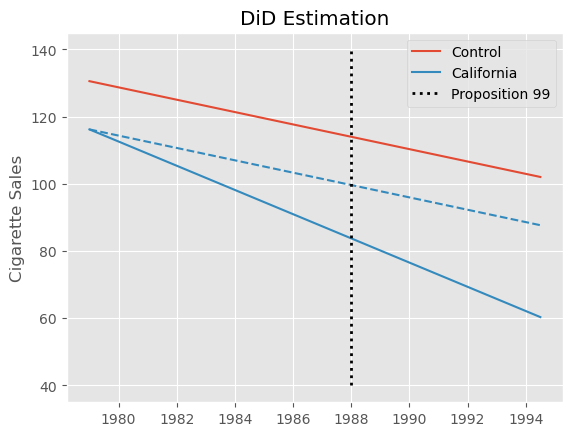

In [33]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

No entanto, esta estimativa deve ser interpretada com cautela. Sabemos que o DiD requer que a tendência no grupo de controle seja igual à do grupo tratado na ausência do tratamento. Formalmente, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. Esta é uma suposição não testável, mas ao observar a tendência pré-tratamento da Califórnia (a unidade tratada) e dos outros estados, podemos ter uma ideia de quão plausível ela é. Especificamente, podemos ver que a tendência em `cigsale` para a Califórnia não é paralela à dos outros estados, pelo menos nos períodos pré-tratamento. As vendas de cigarros na Califórnia estão diminuindo mais rapidamente do que a média dos estados de controle, mesmo antes do tratamento. Se essa tendência se estender além do período pré-tratamento, o estimador DiD será enviesado para baixo, o que significa que o verdadeiro efeito é na verdade menos extremo do que o que estimamos acima.

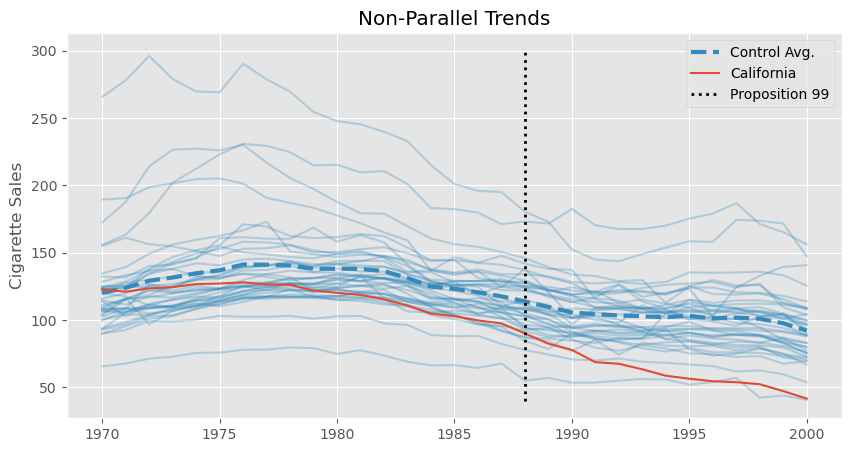

In [35]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

O problema de tendências não paralelas é onde o Controle Sintético entra em jogo no modelo de Diferença em Diferenças Sintéticas. Mas estamos nos adiantando. Independentemente do DiD ser um modelo válido para os dados acima, o que é interessante sobre ele é que podemos reformulá-lo na formulação de Efeitos Fixos Bidirecionais. Para enquadrar o DiD dessa forma, ajustamos médias de unidade ($\alpha_i$) e de tempo ($\beta_t$), juntamente com o indicador de tratamento.
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
Nesta formulação, os efeitos de unidade capturam a diferença nos interceptos para cada unidade, enquanto os efeitos de tempo capturam a tendência geral em ambas as unidades tratadas e de controle. Para implementar isso, poderíamos adicionar variáveis dummy de tempo e unidade ao modelo ou realizar a média dos dados. Neste processo, subtrai-se a média de ambos os tempos e unidades das variáveis de tratamento e resultado:
 
$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$
 
Onde, $\bar{X}_i$ é a média de todos os períodos de tempo para a unidade $i$ e $\bar{X}_t$ é a média de todas as unidades para o tempo $t$:
 
$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$
 
Após realizar a média, uma simples regressão do resultado no indicador de tratamento (`treat*post`) produz o estimador de diferença em diferenças.

In [37]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


Como você pode ver, obtemos o mesmo parâmetro exato de antes. Afinal, ambas as abordagens são simplesmente maneiras diferentes de olhar para o mesmo estimador DiD. No entanto, a razão pela qual essa formulação é muito mais interessante para nosso propósito é que ela nos permite ver como o DiD é na verdade bastante semelhante aos Controles Sintéticos. Observe bem a formulação de Efeitos Fixos Bidirecionais acima. Perceba que é um problema de regressão com efeitos de tempo e efeitos de unidade. Mas note como não há pesos no objetivo de otimização. Essa é a principal diferença entre Diferença em Diferenças e Controles Sintéticos, como veremos em breve.
 
## Controles Sintéticos Revisitados

No estimador canônico de Controles Sintéticos, encontramos **pesos de unidade (estado) que minimizam a diferença entre o resultado pré-tratamento da unidade tratada e a média ponderada do resultado pré-tratamento das unidades de controle** (em um ambiente sem covariáveis). Também impomos a restrição de que os pesos sejam todos positivos e somem até um. Para encontrar esses pesos, resolvemos o seguinte problema de otimização:
 
$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}} \ ||\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}||^2_2 \\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$
 
onde o resultado $\pmb{Y}_{pre, co}$ é uma matriz de dimensões $T_{pre}$ por $N_{co}$, onde as colunas são as unidades e as linhas são os períodos de tempo. $\pmb{w}_{co}$ é um vetor coluna de dimensões $N_{co}$ por 1, com uma entrada para cada unidade. Finalmente, $\pmb{\bar{y}}_{pre, tr}$ é um vetor coluna de dimensões $T_{pre}$ por 1, onde cada entrada é a média temporal das unidades tratadas no período pré-tratamento. É por isso que às vezes chamamos Controle Sintético de uma regressão horizontal. Na maioria dos problemas de regressão, as unidades são as linhas da matriz, mas aqui elas são as colunas. Portanto, estamos regressando o resultado médio das unidades tratadas nas unidades de controle.
 
Assim que encontramos os pesos que resolvem o problema acima, podemos multiplicá-los pelas unidades de controle em todos os períodos de tempo para obter um controle sintético para a unidade tratada:
 
$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$
 
A ideia aqui é que $\pmb{y}_{post, sc}$ é um bom estimador para nossa potencial resultado ausente $Y(0)_{post, tr}$. Se esse for o caso, o $ATT$ é simplesmente a média da unidade tratada no período pós-tratamento menos a média do controle sintético, também no período pós-tratamento.
 
$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$


In [49]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot(index="year", columns="state", values="cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot(index="year", columns="state", values="cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


Esta estimativa é muito menor do que aquela que obtivemos com o DiD. **Controles Sintéticos podem acomodar tendências pré-tratamento não paralelas muito melhor**, portanto, **não são suscetíveis ao mesmo viés que o DiD**. Pelo contrário, o processo de criar um Controle Sintético impõe tendências paralelas, pelo menos no período pré-tratamento. Como resultado, a estimativa que obtemos é muito menor e muito mais plausível.
 
Podemos visualizar esse processo de estimação plotando o resultado real para a Califórnia junto com o resultado do controle sintético. Também plotamos como linhas tracejadas a média pós-intervenção tanto da Califórnia quanto do controle sintético. A diferença entre essas linhas é o $ATT$ estimado.

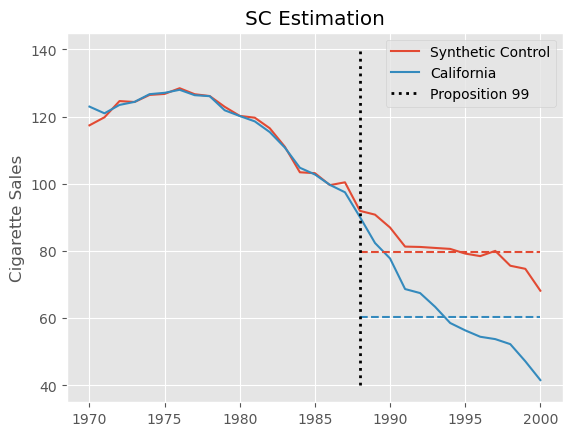

In [51]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

Curiosamente, também podemos reformular o estimador de Controles Sintéticos como a resolução do seguinte problema de otimização, que é bastante semelhante à formulação de Efeitos Fixos Bidirecionais que usamos para o DiD:
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
onde os pesos $\hat{w}^{sc}_i$ para as unidades de controle são estimados a partir do problema de otimização que vimos anteriormente. Para a unidade tratada, os pesos são simplesmente $1/N_{tr}$ (ponderação uniforme).
 
Observe a diferença entre SC e DiD aqui. Primeiro, o Controle Sintético adiciona pesos de unidade $\hat{w}^{sc}_i$ à equação. Segundo, temos efeitos fixos de tempo $\beta_t$, mas não temos efeito fixo de unidade $\alpha_i$, nem um intercepto geral $\mu$.

Para verificar que essas duas formulações são realmente equivalentes, aqui está o código para isso, que produz a mesma estimativa de $ATT$. 

In [55]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


Acabamos de ver como as duas abordagens, CS e DiD, estão realmente intimamente relacionadas. Agora, estamos prontos para falar sobre a Diferença em Diferenças Sintéticas. Como você provavelmente pode imaginar, vamos apenas adicionar pesos ao estimador DiD ou efeitos fixos de unidade ao estimador de Controle Sintético.
 
![img](data/img/sdid/both-pills.png)
 
## Diferença em Diferenças Sintéticas

Antes de mergulharmos no estimador de Diferença em Diferenças Sintéticas, permita-me apenas reproduzir as mesmas equações que vimos anteriormente para CS e DiD, o que facilitará a comparação.
 
$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$
 
$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$
 
Em seguida, como prometido, podemos facilmente mesclar as equações acima em uma que conterá elementos de ambas:
 
$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$
 
Como você pode ver, adicionamos de volta os efeitos fixos de unidade $\alpha_i$. Também mantivemos os pesos de unidade $\hat{w}_i$. Mas há algo novo, que são os **pesos de tempo $\hat{\lambda}_t$**. Não se preocupe. Não há nada complicado sobre eles. Lembra como os pesos de unidade $w_i$ minimizavam a diferença entre as unidades de controle e a média das unidades tratadas? Em outras palavras, usamos eles para igualar a tendência pré-tratamento entre os grupos tratado e de controle. O peso de tempo faz a mesma coisa, mas para os períodos. Ou seja, **ele minimiza a diferença entre os períodos pré e pós-tratamento para os controles**.
 
$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ and } \ \lambda_t > 0 \ \forall \ t
$$
 
Novamente, $\pmb{Y}_{pre, co}$ é uma matriz de dimensões $T_{pre}$ por $N_{co}$ de resultados onde as linhas representam períodos de tempo e as colunas representam as unidades. Mas agora, $\bar{\pmb{y}}_{post, co}$ é um vetor linha de dimensões 1 por $N_{co}$, onde cada entrada é a média temporal do resultado para essa unidade de controle no período pós-tratamento. Finalmente, $\pmb{\lambda}_{pre}$ é um vetor linha de dimensões 1 por $T_{pre}$, com uma entrada para cada período pré-tratamento. Outra maneira de ver isso é perceber que os pesos de unidade $w$ estavam pós-multiplicando a matriz de resultados $\pmb{Y}_{pre, co} \pmb{w}_{co}$. Isso significa que estávamos realizando uma regressão do resultado médio **para cada unidade** do grupo tratado no resultado das unidades do grupo de controle. Agora, estamos invertendo esse problema, realizando uma regressão do resultado médio **para cada período de tempo pós-tratamento** do grupo de controle no resultado das mesmas unidades de controle, mas no período pré-tratamento.
 
Quanto aos pesos de tempo nos períodos pós-tratamento, apenas os configuramos para serem iguais a um sobre o número de períodos pós-tratamento $1/T_{post}$ (novamente, realizando uma ponderação uniforme). Observe que também temos um intercepto $\lambda_0$. Fazemos isso para permitir que o período pós-tratamento esteja acima ou abaixo de todos os períodos pré-tratamento, o que é o caso em muitas aplicações com uma tendência clara positiva ou negativa.

Se tudo isso parecer um pouco abstrato, talvez o código ajude a entender o que está acontecendo.

In [67]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(index=year_col, columns=state_col, values=outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

A primeira coisa que fazemos neste código é filtrar o grupo tratado. Em seguida, pivotamos os dados pré-tratamento para que tenhamos a matriz $\pmb{Y}_{pre,co}$. Em seguida, agrupamos os dados pós-tratamento para obter o resultado médio para cada unidade de controle no período pós-tratamento. Em seguida, adicionamos uma linha cheia de uns no topo de $\pmb{Y}_{pre,co}$, que servirá como o intercepto. Finalmente, regressamos $\bar{\pmb{y}}_{post, co}$ nos períodos pré-tratamento (as linhas de $\pmb{Y}_{pre,co}$) para obter os pesos de tempo $\lambda_t$. Observe como adicionamos as restrições para que os pesos somem 1 e sejam não negativos. Finalmente, descartamos o intercepto e armazenamos os pesos de tempo em uma série.
 
Aqui está o resultado que obtemos ao executar o código acima para encontrar os pesos de tempo no problema da Proposição 99. Observe que todos os períodos, exceto 1986, 87 e 88, recebem pesos zero. Isso significa que uma média ponderada apenas dos últimos 3 períodos é suficiente para equilibrar os períodos pré e pós-tratamento.

In [71]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

Para entender um pouco mais sobre o papel desses pesos, podemos plotar $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ como uma linha horizontal no período pré-tratamento que não é zerada. Ao lado, plotamos o resultado médio no período pós-tratamento. Observe como eles se alinham perfeitamente. Também mostramos os pesos de tempo estimados em barras vermelhas e no eixo secundário.

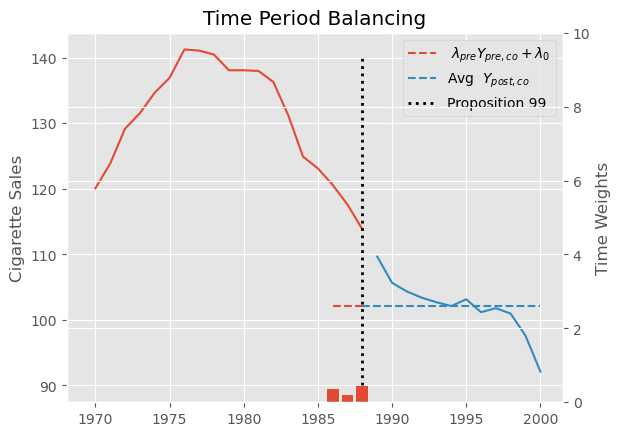

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

Agora que aprendemos o que são os pesos de tempo $\lambda_t$ no estimador de Diferença em Diferenças Sintéticas e como estimá-los, vamos voltar nossa atenção para os pesos de unidade $w_i$. E não, infelizmente, eles não são apenas como os que obtemos ao usar Controles Sintéticos tradicionais. A primeira diferença entre eles é que também permitimos um intercepto $w_0$. Fazemos isso porque **não precisamos mais que a unidade tratada e o controle sintético tenham o mesmo nível**. Como vamos incluir DiD na mistura, só precisamos garantir que o controle sintético e a unidade tratada tenham tendências paralelas.
 
A próxima diferença é que **adicionamos uma penalidade $L_2$ aos pesos. Isso ajuda os pesos não nulos a serem mais distribuídos entre as unidades de controle**, em oposição a ter apenas algumas delas contribuindo para o controle sintético. A penalidade $L_2$ **garante que não tenhamos pesos muito grandes, o que nos obriga a usar mais unidades**.
 
 
$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$


Há também esse termo $\zeta^2$, que é teoricamente fundamentado, mas muito complicado de explicar, então infelizmente deixarei como um pouco de mistério. No artigo de referência, você pode verificar o artigo original, que os explica. Definimos isso assim:
 
$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$
 
onde $\Delta_{it}$ é a primeira diferença nos resultados $Y_{it} - Y_{i(t-1)}$ e $\sigma(\Delta_{it})$ é o desvio padrão dessa diferença. Aqui está o código para calcular isso.

In [77]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

Quanto aos pesos de unidade, não há nada especialmente novo neles. Podemos reutilizar grande parte do código da função para estimar os pesos de tempo. Só precisamos ter cuidado com as dimensões, já que o problema está de cabeça para baixo agora.

In [83]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

Primeiro, calculamos $\zeta$ usando a função que definimos anteriormente e filtramos o período pós-tratamento. Em seguida, pivotamos os dados pré-tratamento para obter a matriz de resultados $\bar{\pmb{y}}_{pre, tr}$. Depois, adicionamos uma coluna cheia de uns no início da matriz $\bar{\pmb{y}}_{pre, tr}$. Essa coluna nos permitirá estimar o intercepto. Com tudo isso, definimos o objetivo de otimização, que inclui a penalidade $L_2$ nos pesos. Finalmente, descartamos o intercepto e armazenamos os pesos estimados em uma série.

Se usarmos este código para estimar os pesos de unidade no problema da Proposição 99, aqui está o resultado que obtemos para os primeiros 5 estados:

In [85]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

Esses pesos de unidade também definem um controle sintético que podemos plotar junto com o resultado da Califórnia. Também plotaremos o controle sintético tradicional que estimamos anteriormente junto com o que acabamos de estimar mais o termo de interceptação. Isso nos dará alguma intuição sobre o que está acontecendo e a diferença entre o que acabamos de fazer e o Controle Sintético tradicional.

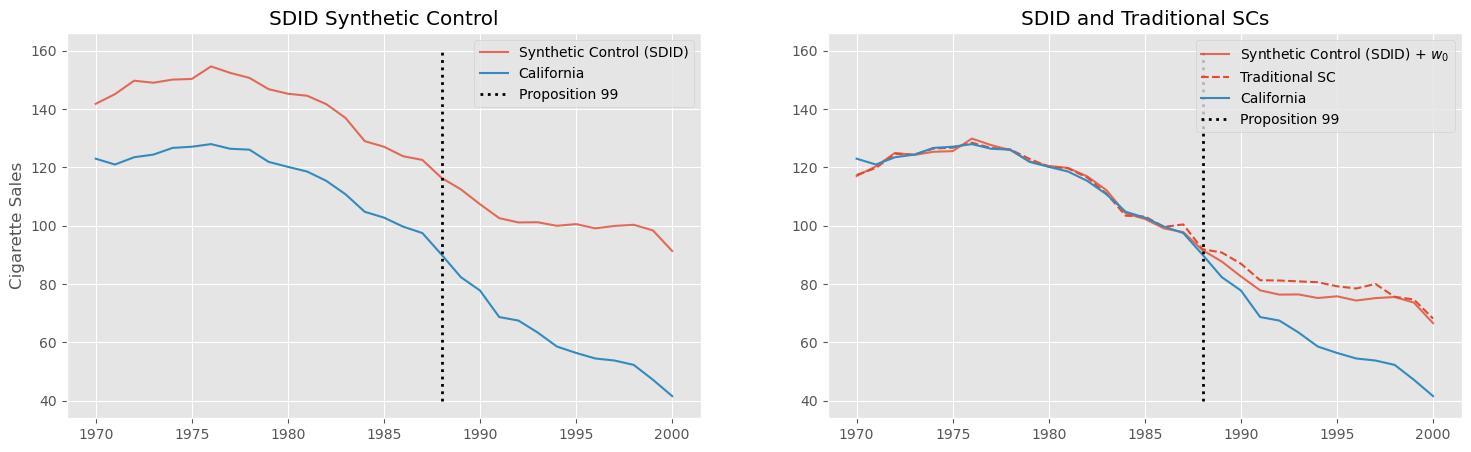

In [87]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

Como podemos ver no primeiro gráfico, a diferença óbvia é que esse novo controle sintético não está mais em cima da Califórnia. Isso ocorre porque incluímos um intercepto, o que permite que a unidade tratada esteja em um nível arbitrariamente diferente de seu controle sintético. Este novo método de Controle Sintético é construído para ter a mesma tendência pré-tratamento da unidade tratada, mas não necessariamente o mesmo nível. 
 
No segundo gráfico, ajustamos este novo CS adicionando de volta o intercepto que removemos anteriormente. Isso o coloca em cima da unidade tratada, a Califórnia. Para comparação, mostramos o CS tradicional que ajustamos anteriormente como a linha tracejada vermelha. Observe que eles não são iguais. Essa diferença decorre tanto do fato de que permitimos um intercepto quanto da penalidade $L_2$, que empurrou os pesos para zero.
 
Agora que temos tanto os pesos de tempo $\hat{\lambda}_t$ quanto os pesos de unidade $\hat{w}_t$, podemos prosseguir com a execução da parte DiD do estimador DiD sintético. Para esta parte, é melhor se trabalharmos com os dados no formato de uma tabela com linhas $N$ por $T$, onde temos colunas para os estados, os anos, o resultado, o indicador pós-tratamento e o indicador de unidade tratada. Para essa tabela, adicionaremos os pesos de tempo e de unidade. Como o peso de tempo está em uma série com um índice de tempo e o peso de unidade está em outra série com um índice de unidade, podemos simplesmente juntar tudo.

In [89]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

Esse processo de junção deixará `null` para os pesos de unidade no grupo tratado e para os pesos de tempo no período pós-tratamento. Felizmente, porque usamos ponderação uniforme em ambos os casos, é bastante fácil preencher esses `null`s. Para os pesos de tempo, preenchemos com a média do indicador pós-tratamento, que será $1/T_{post}$; para os pesos de unidade, preenchemos com a média do indicador tratado, que será $1/N_{tr}$. Finalmente, multiplicamos ambos os pesos juntos.

Aqui está o resultado que obtemos ao executar este código nos dados da Proposição 99:

In [91]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600034e-14,-1.360924e-16,0.0
1,1971,1,95.400002,0,0,-4.582315e-14,-1.360924e-16,0.0
2,1972,1,101.099998,0,0,-5.274190e-14,-1.360924e-16,0.0
3,1973,1,102.900002,0,0,-5.766356e-14,-1.360924e-16,0.0
4,1974,1,108.199997,0,0,-5.617979e-14,-1.360924e-16,0.0


In [93]:
data["after_treatment"].mean()

0.3870967741935484

In [95]:
1/len(data.query("after_treatment==1")["year"].unique())

0.08333333333333333

Finalmente, tudo o que precisamos fazer é estimar um modelo de Diferença em Diferenças com os pesos que acabamos de definir. A estimativa do parâmetro associado ao termo de interação para o período pós-tratamento e indicador tratado será a estimativa de Diferença em Diferenças Sintéticas para o $ATT$.

In [97]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.272,94.665,0.000,117.911,122.901
after_treatment,-19.1905,1.799,-10.669,0.000,-22.720,-15.661
treated,-25.2601,1.799,-14.043,0.000,-28.789,-21.731
after_treatment:treated,-15.6054,2.544,-6.135,0.000,-20.596,-10.615


Essa estimativa é muito menor do que a que obtemos com o Diff-in-Diff, mas isso não é surpreendente. Como já discutimos, o estimador de Diff-in-Diff provavelmente está enviesado neste caso, pois temos boas razões para questionar a suposição de tendências paralelas. **O que talvez seja menos óbvio é por que a estimativa de SDID é menor do que a estimativa tradicional de SC**. Se voltarmos e olharmos o gráfico de SC, podemos ver que as vendas de cigarros na Califórnia começaram a cair abaixo de seu controle sintético antes da Proposition 99. Isso provavelmente se deve ao fato de que o Controle Sintético tradicional precisa combinar unidades tratadas e de controle durante todo o período pré-tratamento, fazendo com que ele perca um ano ou outro. Isso é menos problemático no SDID, uma vez que os pesos de tempo nos permitem focar apenas nos períodos que são mais semelhantes ao período pós-intervenção. Neste caso, esses foram precisamente os três anos que antecederam a Proposition 99.
 
Para entender o que o SDID está fazendo, podemos plotar as linhas de Diff-in-Diff para a unidade tratada (Califórnia) e o Controle Sintético SDID. Observe como estamos projetando a tendência que vemos no controle sintético na unidade tratada para obter o contrafactual $Y(0)_{tr, post}$. A diferença entre a linha tracejada roxa e a linha roxa sólida inferior é o $ATT$. Iniciamos essas linhas em 1987 para mostrar como os pesos de tempo zeram todos os períodos, exceto 1986, 87 e 88. Os pesos de tempo também são mostrados no gráfico pequeno abaixo.

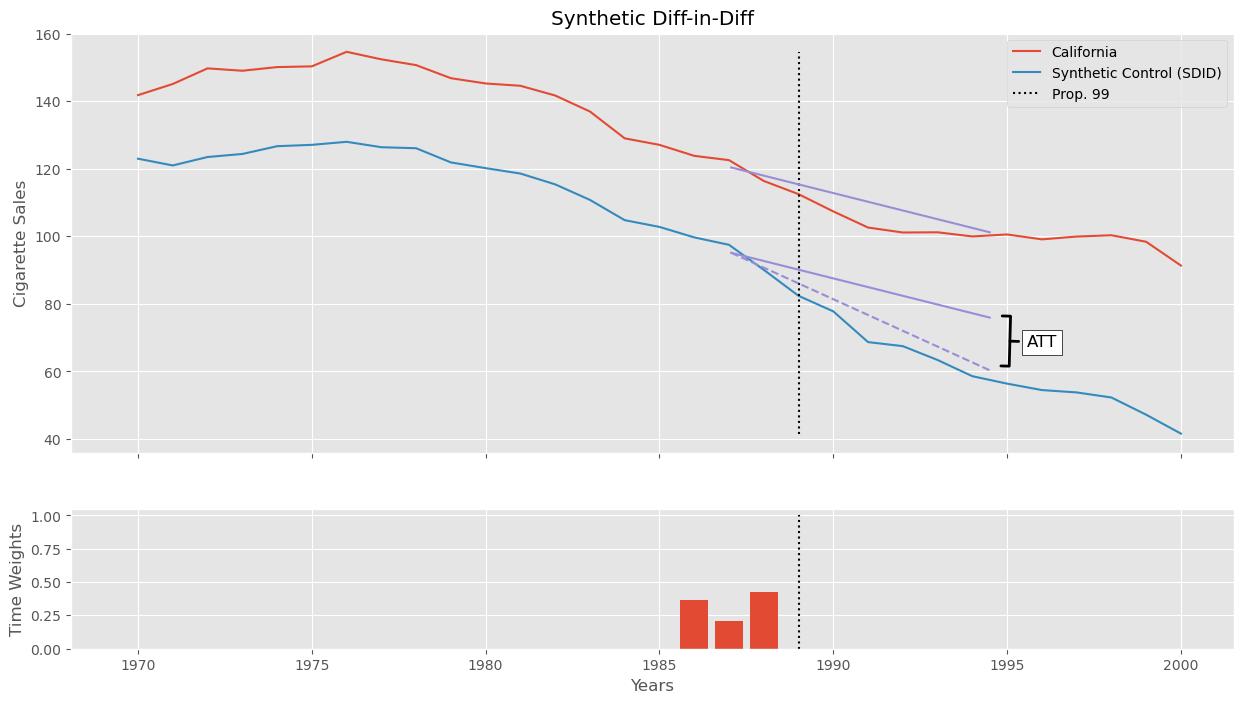

In [99]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")

ax1.annotate('ATT', xy=(1995, 69), xytext=(1996, 66.5), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=2.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

O estimador acima estima o $ATT$, que é o efeito da Proposição 99 na Califórnia, considerando todos os períodos pós-tratamento. No entanto, a partir do gráfico acima, parece que o efeito aumenta ao longo do tempo. E se quisermos levar isso em consideração? Felizmente, é muito simples fazer isso.

Antes de avançarmos, apenas uma palavra de cautela sobre o estimador acima. Você **não** deve confiar nos erros padrão ou intervalos de confiança relatados pela regressão que acabamos de executar. Eles não refletem a variância na estimativa dos pesos. Vamos dar uma olhada em como fazer inferência adequada em breve, mas primeiro, vamos ver como lidar com a heterogeneidade do efeito ao longo do tempo.
 
## Heterogeneidade do Efeito Temporal e Adoção Escalonada

Felizmente, **é incrivelmente fácil estimar um efeito para cada período de tempo usando o SDiD**. Tudo o que temos que fazer é **executá-lo várias vezes, uma para cada período de tempo**. Para ser mais preciso, digamos que temos a seguinte matriz de atribuição de tratamento, com apenas 4 períodos de tempo e 3 unidades. A última unidade é a tratada.
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
Executar o SDiD com a matriz acima nos daria o $ATT$ médio nos períodos 3 e 4. O que podemos fazer para estimar o efeito em cada período individualmente é simplesmente dividir o problema em dois, um para cada período de tempo pós-tratamento. Em seguida, executamos o SDiD nos dados onde mantemos apenas o período pós-tratamento 3 e novamente nos dados onde mantemos apenas o período pós-tratamento 4. Ou seja, executamos o SDiD em cada uma das seguintes matrizes individualmente.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$
 
Para fazer isso, seria melhor se primeiro consolidássemos todas as etapas do SDiD em uma única função. Isso é, estimar os pesos de unidade e tempo e executar o DiD.

In [101]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605397234586789

Agora que temos uma maneira fácil de executar o SDID, podemos executá-lo várias vezes, filtrando todos os períodos pós-tratamento, exceto aquele para o qual queremos o efeito.

In [103]:
effects = {year: synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})"), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        state_col="state",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

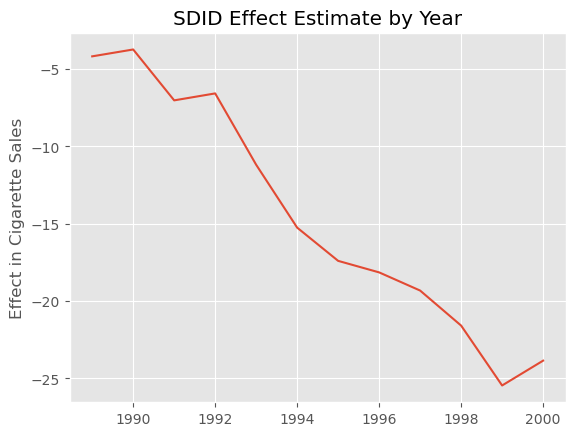

In [107]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

Conforme esperado, o efeito fica maior à medida que o tempo passa. **Começa pequeno, mas aumenta gradualmente para o que parece ser uma redução no consumo de 25 maços de cigarro per capita em 2020.**

Convenientemente, **executar o SDID várias vezes também será importante para lidar com o caso de adoção escalonada**. Com o design de adoção escalonada, **temos várias unidades tratadas, que recebem o tratamento em diferentes períodos de tempo**. Por exemplo, voltando para a nossa matriz de atribuição simplificada, com 3 unidades e 4 períodos de tempo, digamos que a unidade 1 nunca recebe o tratamento, a unidade 2 recebe o tratamento no período 4 e a unidade 3 recebe o tratamento no período 3. Isso resultaria na seguinte matriz:
 
$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
Observe que o SDID não pode lidar com essa matriz, porque não temos uma definição clara do que é um período pré-tratamento (antes do tempo 4, no caso da segunda unidade ou antes do período 3, no caso da terceira unidade) ou o que é uma unidade de controle (a unidade 2 poderia ser uma unidade de controle para o tratamento iniciando no período 3). A chave para resolver isso é perceber que podemos excluir colunas (unidades) ou linhas (períodos de tempo) nessa matriz para voltar ao design de atribuição por blocos.

Por exemplo, podemos criar duas matrizes de bloco a partir da acima, primeiro excluindo o 3º período de tempo e depois outra em que excluímos o 4º período de tempo.
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$
 
 
O resultado são duas matrizes de blocos, o que significa que podemos executar o SDID em ambas. O resultado será duas estimativas de $ATT$, que podemos combinar com uma média ponderada, onde os pesos são a proporção de tempo e períodos tratados em cada bloco. Em nosso exemplo, o peso para $ATT_1$ seria $2/3$ e o peso para $ATT_2$ seria 1/3.

Alternativamente, também poderíamos ter 2 designs de bloco removendo colunas, o que resultaria nas seguintes matrizes:
 
$$
D_1 = \begin{bmatrix}
    0_1 & 0_1  \\
    0_2 & 0_2  \\
    0_3 & 0_3  \\
    0_4 & 1_4  \\
\end{bmatrix}
$$
 
$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 \\
    0_2 & 0_2 \\
    0_3 & 1_3 \\
    0_4 & 1_4 \\
\end{bmatrix}
$$
 
onde $D_1$ possui as unidades 1 e 2 e $D_2$ possui as unidades 1 e 4.

Como já vimos como estimar o SDID para diferentes períodos de tempo, vamos olhar para esta abordagem em que filtramos unidades. Como não temos originalmente um design de adoção escalonada em nossos dados da Proposição 99, vamos simular um. Criaremos 3 novos estados a partir de nossos dados e fingiremos que eles aprovaram uma lei semelhante à Proposição 99, mas no ano de 1993. Talvez eles tenham ficado impressionados com os resultados na Califórnia e quisessem tentar em seus estados também. Quando o fizerem, a lei que aprovarem diminui o consumo de cigarros em 3% a cada ano. Podemos visualizar o consumo médio de cigarros para esses novos estados para entender melhor o que está acontecendo. Em preto tracejado, temos o ano em que esses estados aprovam essa lei antitabagismo.

In [109]:
np.random.seed(1)
n = 3
tr_state = (data
            .query(f"state.isin({list(np.random.choice(data['state'].unique(), n))})")
            .assign(**{
                "treated": True,
                "state": lambda d: "new_" + d["state"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] - 
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_state]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], False)})

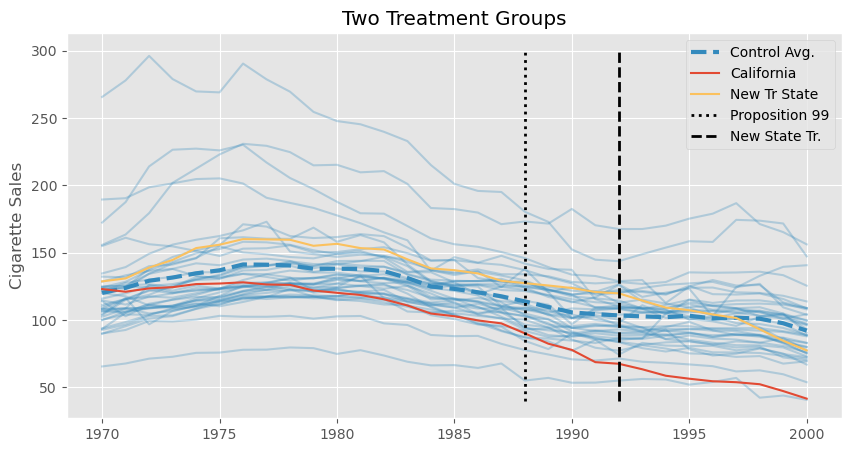

In [113]:
new_data_piv = new_data.pivot(index="year", columns="state", values="cigsale")

new_tr_states = list(filter(lambda c: str(c).startswith("new"), new_data_piv.columns))

plt.figure(figsize=(10,5))
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states), color="C1", alpha=0.3)
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_data_piv["california"], color="C0", label="California")
plt.plot(new_data_piv[new_tr_states].mean(axis=1), color="C4", label="New Tr State")

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=2, label="New State Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

Finalmente, temos esses dados de adoção escalonada. Agora, precisamos descobrir como filtrar alguns estados para que possamos dividir o problema em vários casos de atribuição por blocos. Primeiro, podemos agrupar os estados pelo ano em que aprovaram a lei. O código a seguir faz exatamente isso.

In [117]:
assignment_blocks = (new_data.query("treated & after_treatment")
                     .groupby("state")["year"].min()
                     .reset_index()
                     .groupby("year")["state"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

Como você pode ver, temos dois grupos de estados. Um com apenas a Califórnia, que foi tratada a partir de 1989, e outro com os três novos estados que criamos, que foram todos tratados a partir de 1993. Agora, precisamos executar o SDID para cada um desses grupos. Podemos fazer isso facilmente, mantendo apenas as unidades de controle mais um desses grupos. Há um detalhe, no entanto. A coluna `after_treatment` terá um significado diferente, dependendo do grupo que estamos analisando. Se estivermos olhando para o grupo que contém apenas a Califórnia, `after_treatment` deve ser `year >= 1989`; se estivermos olhando para o grupo com os novos estados, deve ser `year >= 1993`. Felizmente, isso é bastante fácil de levar em conta. Tudo o que precisamos fazer é recriar o `after_treatment` em cada iteração.

In [119]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                   .query(f"~treated|(state.isin({states}))")
                                                   .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  state_col="state",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
                     for year, states in assignment_blocks.items()}

staggered_effects

{1989: -15.605397234586789, 1993: -17.249435402003705}

Não surpreendentemente, a estimativa de $ATT$ para o primeiro grupo, aquele com apenas a Califórnia, é exatamente a mesma que vimos anteriormente. O outro $ATT$ refere-se ao que obtemos com o novo grupo de estados. Precisamos combiná-los em um único $ATT$. Isso pode ser feito com a média ponderada que explicamos anteriormente.

Primeiro, calculamos o número de entradas tratadas (`after_treatment & treated`) em cada bloco. Em seguida, combinamos os $ATT$s usando esses pesos.

In [121]:
weights = {year: sum((new_data["year"] >= year) & (new_data["state"].isin(states)))
           for year, states in assignment_blocks.items()}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])

print("weights: ", weights)
print("ATT: ", att)

weights:  {1989: 12, 1993: 24}
ATT:  -16.7014226795314


Aqui, temos um total de 36 instâncias de tratamento: os habituais 12 períodos pós-tratamento para a Califórnia, além de 8 períodos de tratamento (1993-2000) para cada um dos três novos estados de tratamento que introduzimos. Com isso em mente, o peso para o primeiro $ATT$ é $12/36$ e para o segundo $ATT$, $24/36$, resultando na estimativa acima.
 
## Estimativa de Variância Placebo

Este capítulo está ficando um pouco longo, mas há uma promessa que ainda não cumprimos. Lembra como dissemos, no início, que o SDID tem uma melhor precisão (menores barras de erro) em comparação com os Controles Sintéticos? A razão é que os efeitos fixos de tempo e unidade no SDID capturam muita variação no resultado, o que, por sua vez, reduz a variância do estimador.
 
É claro que não vou pedir para você acreditar somente na minha palavra, então a seguir mostraremos como criar um intervalo de confiança em torno do estimador SDID. Acontece que existem muitas soluções para esse problema, mas apenas uma que se encaixa no caso de um único tratamento, que é o caso que temos aqui, já que apenas a Califórnia foi tratada. A ideia é executar uma série de testes de placebo, onde fingimos que uma unidade do grupo de controle foi tratada, quando na verdade não foi. Em seguida, usamos o SDID para estimar o $ATT$ deste teste de placebo e armazenamos o resultado. Repetimos este passo várias vezes, amostrando uma unidade de controle a cada vez. No final, teremos uma matriz de valores de $ATT$ de placebo. A variância desta matriz é a variância de placebo do estimador do efeito SDID, que podemos usar para construir um intervalo de confiança.
 
$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
Para implementar isso, a primeira coisa que precisamos é uma função que cria o placebo. Essa função filtrará as unidades tratadas, amostrará uma única unidade de controle e alterará a coluna `treated` para essa unidade de controle de 0 para 1.

In [123]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states)
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [125]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")

placebo_data.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


No exemplo acima, amostramos o estado 39 e agora estamos fingindo que ele foi tratado. Observe como a coluna `treated` foi alterada para `True`.

A próxima coisa que precisamos fazer é calcular a estimativa do SDID com esses dados de placebo e repetir isso várias vezes. A próxima função faz isso. Ela executa a função `synthetic_diff_in_diff` para obter a estimativa do SDID, mas em vez de passar os dados usuais, passamos o resultado chamando `make_random_placebo`. Fazemos isso várias vezes para obter uma matriz de estimativas do SDID e, finalmente, calculamos a raiz quadrada da variância dessa matriz, que é apenas o desvio padrão.

In [127]:
from joblib import Parallel, delayed # for parallel processing


def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)
    
    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      state_col=state_col,
                      treat_col=treat_col,
                      post_col=post_col)
    
    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, state_col=state_col, treat_col=treat_col))
                                     for _ in range(bootstrap_rounds))
    
    return np.std(effects, axis=0)


In [129]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

O desvio padrão pode então ser usado para construir intervalos de confiança, da mesma forma que descrevemos na fórmula acima.

In [130]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.605397234586789
Standard Error: 9.912089736240253
90% CI: (-31.960345299383206, 0.7495508302096283)


Observe que o $ATT$ não é significativo neste caso, mas o que é mais interessante aqui é comparar o erro padrão da estimativa do SDID com o que obtemos do Controle Sintético tradicional.

In [133]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(index=year_col,columns= state_col, values=outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(index=year_col, columns=state_col, values=outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [134]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 11.241934948975809
90% CI: (-38.06282242980862, -0.9644370981884549)


Observe como o erro para o controle sintético é maior do que para o SDID. Novamente, isso ocorre porque o SDID captura grande parte da variância no resultado por meio de seus efeitos fixos no tempo e na unidade. Com isso, cumprimos a promessa que fizemos anteriormente. No entanto, antes de encerrar, vale mencionar que também podemos usar o mesmo procedimento para estimar a variância e construir um intervalo de confiança em torno do efeito que estimamos para cada período pós-tratamento. Tudo o que precisamos fazer é executar o código acima uma vez para cada período de tempo pós-tratamento. Apenas tenha em mente que isso pode levar algum tempo para ser executado, mesmo com a paralelização que implementamos.

In [137]:
standard_errors = {year: estimate_se(data.query(f"~after_treatment|(year=={year})"), 
                                     outcome_col="cigsale",
                                     year_col="year",
                                     state_col="state",
                                     treat_col="treated",
                                     post_col="after_treatment")
                   for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

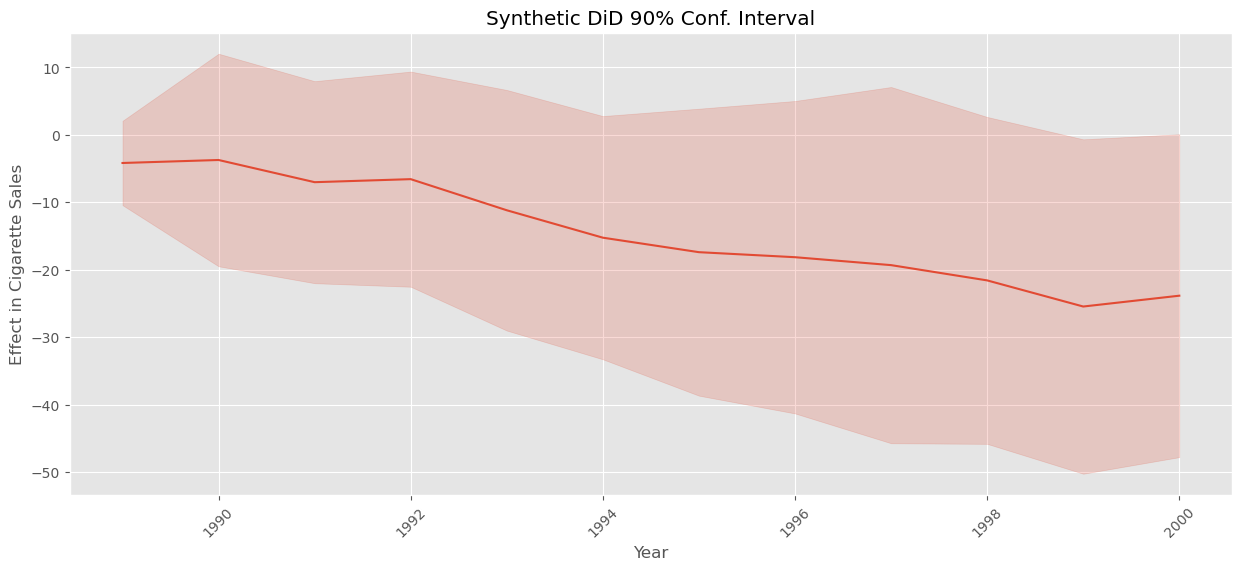

In [138]:
plt.figure(figsize=(15,6))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2,  color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## Conceitos-chave

O Diff-in-Diff Sintético (SDID) se inspira tanto no Diff-in-Diff quanto no Controle Sintético, trazendo vantagens de ambos os modelos. Como o SC, o SDID ainda funciona com vários períodos quando as tendências pré-tratamento não são paralelas. No entanto, ao contrário do SC, o SDID estima pesos de unidade para construir uma unidade de controle que é apenas paralela ao grupo tratado (não precisa coincidir com seu nível). Do DID, o SDID utiliza efeitos fixos no tempo e na unidade, o que ajuda a explicar grande parte da variância no resultado, reduzindo assim a variância do estimador SDID. O Diff-in-Diff Sintético também introduz algumas ideias novas. Primeiro, há uma penalidade adicional de $L2$ na otimização dos pesos da unidade, o que os distribui mais entre as unidades de controle. Em segundo lugar, o SDID permite um intercepto (e, portanto, extrapolação) ao construir esses pesos. Em terceiro lugar, o SDID introduz o uso de pesos temporais, que não estão presentes no DID nem no SC. Por esse motivo, eu não diria que o SDID está apenas fundindo o SC e o DID. Ele está construindo algo novo, inspirado por essas duas abordagens. Também não diria que o SDID é melhor ou pior que o Controle Sintético tradicional. Cada um deles tem propriedades diferentes que podem ser apropriadas ou não, dependendo da situação. Por exemplo, você pode se encontrar em uma situação em que permitir as extrapolações do SDID seja perigoso. Nesse caso, o SC pode ser uma boa alternativa.


## Referências

Este capítulo é essencialmente uma explicação do artigo *Synthetic Difference in Differences* (2019), de Dmitry Arkhangelsky, Susan Athey, David A. Hirshberg, Guido W. Imbens e Stefan Wager. Além disso, gostaria de reconhecer Masa Asami pela implementação em Python do SDID, pysynthdid. Seu código me ajudou a garantir que eu não tivesse bugs no meu, o que foi extremamente útil.
 
 
## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<div align="center">
<a href="24-The-Diff-in-Diff-Saga.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="Debiasing-with-Orthogonalization.ipynb">Próximo --></a>  

<a href="https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html">[25 - Synthetic Difference-in-Differences]</a>  
</div>